In [1]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS

In [2]:
dsm_directory = '/Users/dorian/Documents/2024_2/Capstone/lds-waikato-region-3layers-GTiff/waikato-lidar-1m-dsm-2021'
dem_directory = '/Users/dorian/Documents/2024_2/Capstone/lds-waikato-region-3layers-GTiff/waikato-lidar-1m-dem-2021'
aer_directory = '/Users/dorian/Documents/2024_2/Capstone/lds-waikato-region-3layers-GTiff/waikato-03m-rural-aerial-photos-2021-2023'

# DEM DSM group by name

In [3]:
# base_name --> [DEM(image, transform), DSM(image, transform)]
data = {}

for filename in os.listdir(dem_directory):
    if filename.endswith('.tif'):
        base_name = filename[19:23] # four digit name
        print('******', base_name, '******')
        dem = os.path.join(dem_directory, filename)
        dsm = dsm_directory + '/DSM' + filename[3:]
        with rasterio.open(dem) as src:
            data[base_name] = [(src.read()[0], src.transform)]
            print('transform')
            print(data[base_name][0][1])
            print('shape', src.shape)
        with rasterio.open(dsm) as src:
            data[base_name].append((src.read()[0], src.transform))

****** 4521 ******
transform
| 1.00, 0.00, 1813600.00|
| 0.00,-1.00, 5878320.00|
| 0.00, 0.00, 1.00|
shape (612, 480)
****** 4520 ******
transform
| 1.00, 0.00, 1813214.00|
| 0.00,-1.00, 5878320.00|
| 0.00, 0.00, 1.00|
shape (612, 386)
****** 4522 ******
transform
| 1.00, 0.00, 1814080.00|
| 0.00,-1.00, 5878320.00|
| 0.00, 0.00, 1.00|
shape (612, 480)
****** 4523 ******
transform
| 1.00, 0.00, 1814560.00|
| 0.00,-1.00, 5878320.00|
| 0.00, 0.00, 1.00|
shape (612, 480)
****** 4524 ******
transform
| 1.00, 0.00, 1815040.00|
| 0.00,-1.00, 5878320.00|
| 0.00, 0.00, 1.00|
shape (612, 254)
****** 4422 ******
transform
| 1.00, 0.00, 1814080.00|
| 0.00,-1.00, 5878959.00|
| 0.00, 0.00, 1.00|
shape (639, 480)
****** 4423 ******
transform
| 1.00, 0.00, 1814560.00|
| 0.00,-1.00, 5878959.00|
| 0.00, 0.00, 1.00|
shape (639, 480)
****** 4421 ******
transform
| 1.00, 0.00, 1813600.00|
| 0.00,-1.00, 5878959.00|
| 0.00, 0.00, 1.00|
shape (639, 480)
****** 4420 ******
transform
| 1.00, 0.00, 1813214.00|
|

.tfw files as well as .tif 'transform', which contain geographic information on bitmaps, is ASCII text files describing the location, scale and orientation of an image. These world files are six-line files with decimal numbers separated by dots on each line.

1.000000000000000  
0.000000000000000  
0.000000000000000  
-1.000000000000000  
1813214.500000000232831  
5878958.500000000000000

The values mean:  
Line 1: length of a pixel in the x direction (horizontal)  
Line 2: angle of rotation (is usually 0 or ignored)  
Line 3: angle of rotation (is usually 0 or ignored)  
Line 4: negative length of a pixel in the y direction (vertical)  
Line 5: x coordinate at the center of the pixel in the top left corner of the image  
Line 6: y coordinate at the center of the pixel in the top left corner of the image

shape (n_row, n_col) order is (y, x), should not be confused

# Aerial

In [4]:
for filename in os.listdir(aer_directory):
    if filename.endswith('.tif'):
        with rasterio.open(os.path.join(aer_directory, filename)) as src:
            aer_data = (src.read(), src.transform)
            print('transform')
            print(aer_data[1])
            print('shape', src.shape)

transform
| 0.30, 0.00, 1813214.70|
| 0.00,-0.30, 5878958.40|
| 0.00, 0.00, 1.00|
shape (4165, 6930)


# UTM vs NZTM2000 Coord

Sphere surface: The closer to poles, the shorter distance represented by 1 unit of longitude. NZTM2000 is centered on a meridian that runs through New Zealand to help minimize distortion across the country, which is crucial for accurate mapping.

Dynamic Earth: New Zealand sits on the boundary of the Pacific and Australian tectonic plates, which causes the country to move by several cm each year. NZGD2000 (New Zealand Geodetic Datum 2000) is designed to represent the Earth’s surface at a specific epoch (2000.0) and can be adjusted for the tectonic movement since that epoch, ensuring that coordinates remain accurate over time despite the ongoing movement.

Universal Transverse Mercator (UTM) system is global, divided into zones that might not align perfectly with a specific country’s needs. NZTM2000 provides a single coordinate system for the entire country, whereas using UTM would require dealing with multiple zones.

In the context of NZTM2000:  
x East: Moving eastward increases the x-coordinate (easting) by adding that distance in meters to x-coordinate.  
y South: Moving southward decreases the y-coordinate (northing) by subtracting that distance in meters from y-coordinate.

In [5]:
# Define CRS for NZTM2000, UTM, and WGS84 (for lat/lon)
nztm2000_crs = CRS.from_epsg(2193)  # NZGD2000 / New Zealand Transverse Mercator 2000
utm_crs = CRS.from_epsg(32759)      # UTM Zone 59S (southern hemisphere)
wgs84_crs = CRS.from_epsg(4326)     # WGS84 (latitude and longitude)

# Create transformers
nztm_to_latlon_transformer = Transformer.from_crs(nztm2000_crs, wgs84_crs, always_xy=True)
nztm_to_utm_transformer = Transformer.from_crs(nztm2000_crs, utm_crs, always_xy=True)
utm_to_latlon_transformer = Transformer.from_crs(utm_crs, wgs84_crs, always_xy=True)

# Example coordinates in NZTM2000 (replace with actual values)
x_nztm2000 = aer_data[1].c  # X coordinate in NZTM2000
y_nztm2000 = aer_data[1].f  # Y coordinate in NZTM2000

# Convert NZTM2000 to Lat/Lon
lon_nztm, lat_nztm = nztm_to_latlon_transformer.transform(x_nztm2000, y_nztm2000)

# Convert NZTM2000 to UTM
x_utm, y_utm = nztm_to_utm_transformer.transform(x_nztm2000, y_nztm2000)
# Convert UTM to Lat/Lon
lon_utm, lat_utm = utm_to_latlon_transformer.transform(x_utm, y_utm)

# Print results for comparison
print(f"NZTM2000 to Lat/Lon: Latitude: {lat_nztm}, Longitude: {lon_nztm}")
print(f"NZTM2000 to UTM: Xcoord: {x_utm}, Ycoord: {y_utm}")
print(f"UTM to Lat/Lon: Latitude: {lat_utm}, Longitude: {lon_utm}")


NZTM2000 to Lat/Lon: Latitude: -37.21151610256756, Longitude: 175.4027968415216
NZTM2000 to UTM: Xcoord: 890759.8093504454, Ycoord: 5872573.173017666
UTM to Lat/Lon: Latitude: -37.21151610256755, Longitude: 175.4027968415216


# Plot DEM DSM group

In [6]:
# Determine global vmin and vmax across all DEM and DSM images
all_values = []
for dem_data, dsm_data in data.values():
    all_values.append(dem_data[0].flatten())
    all_values.append(dsm_data[0].flatten())
all_values = np.concatenate(all_values)

# Exclude outliers by using percentiles
vmin = np.percentile(all_values, 2)
vmax = np.percentile(all_values, 98)

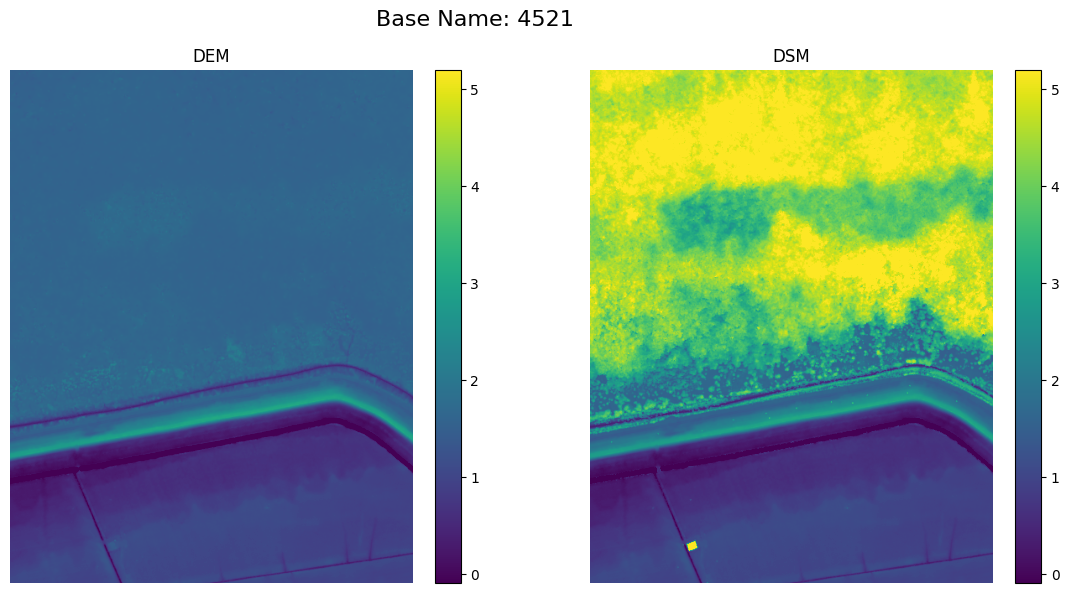

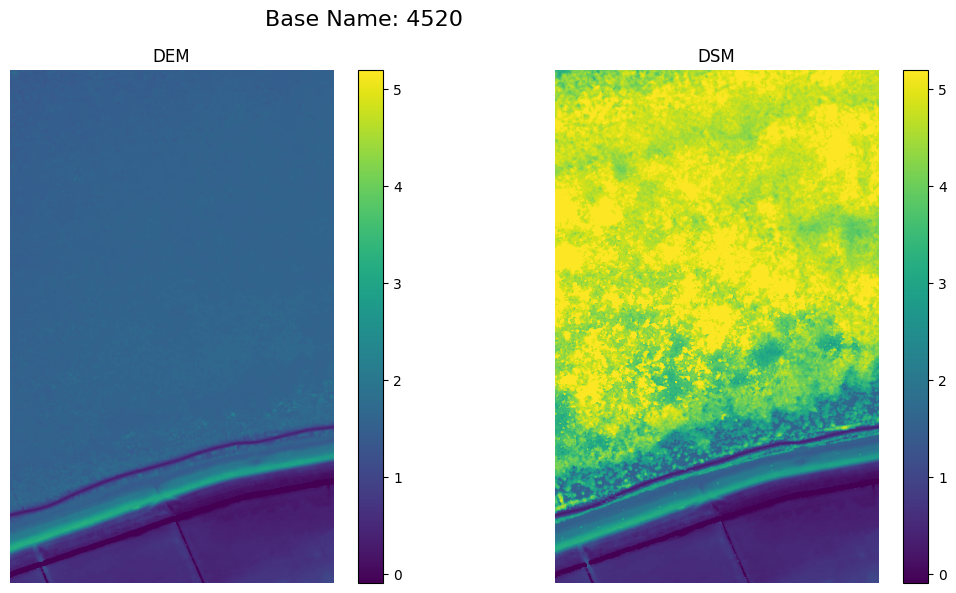

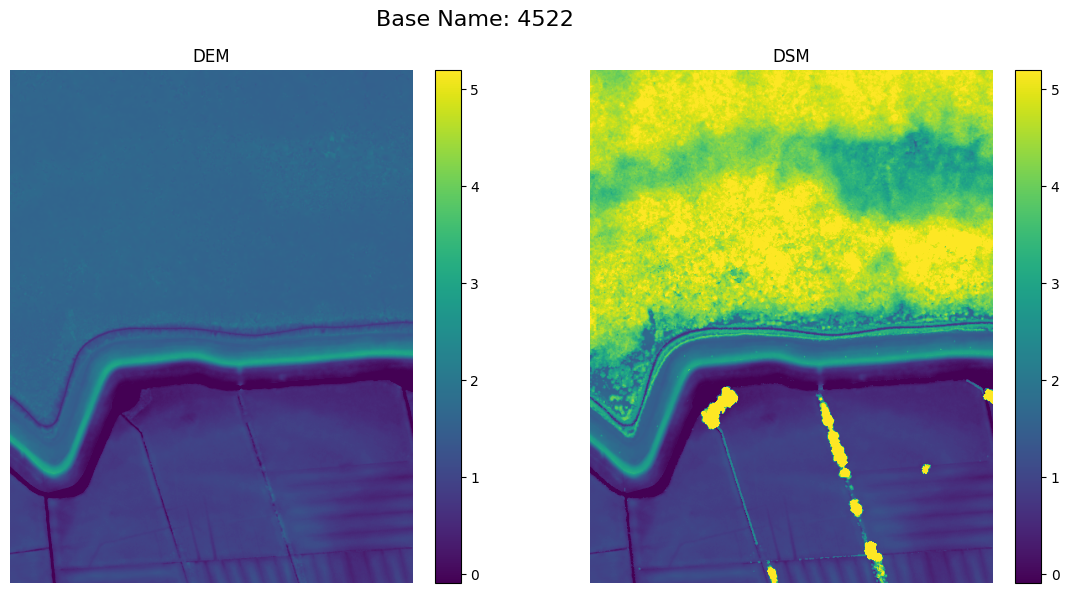

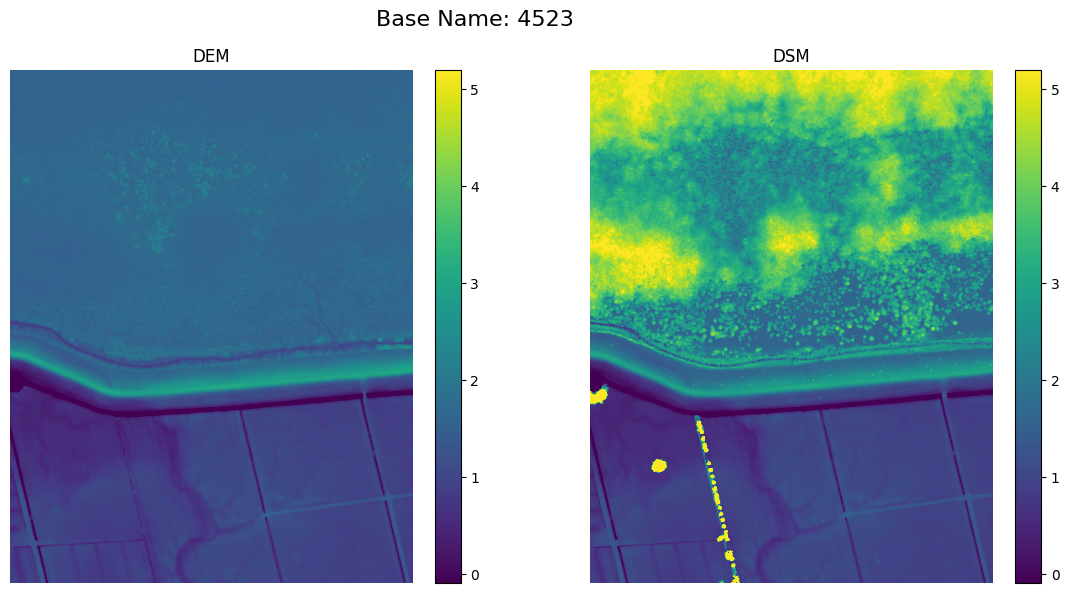

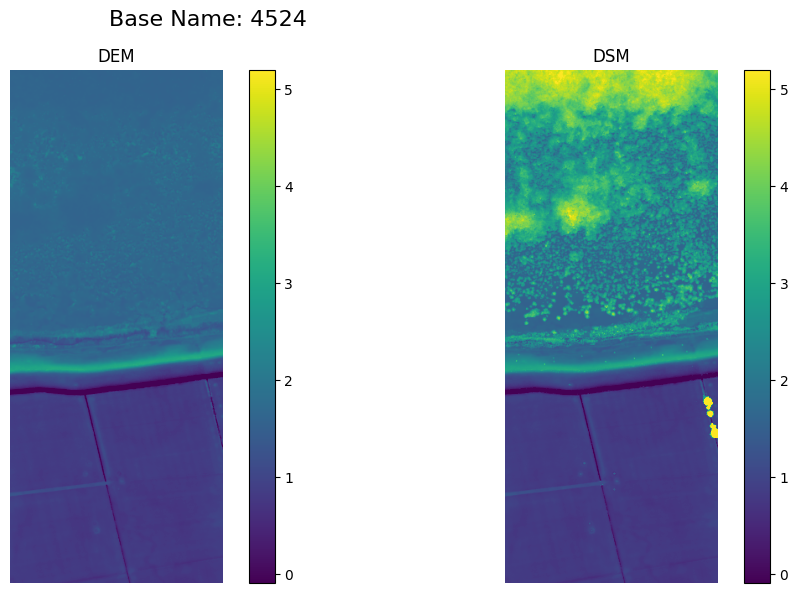

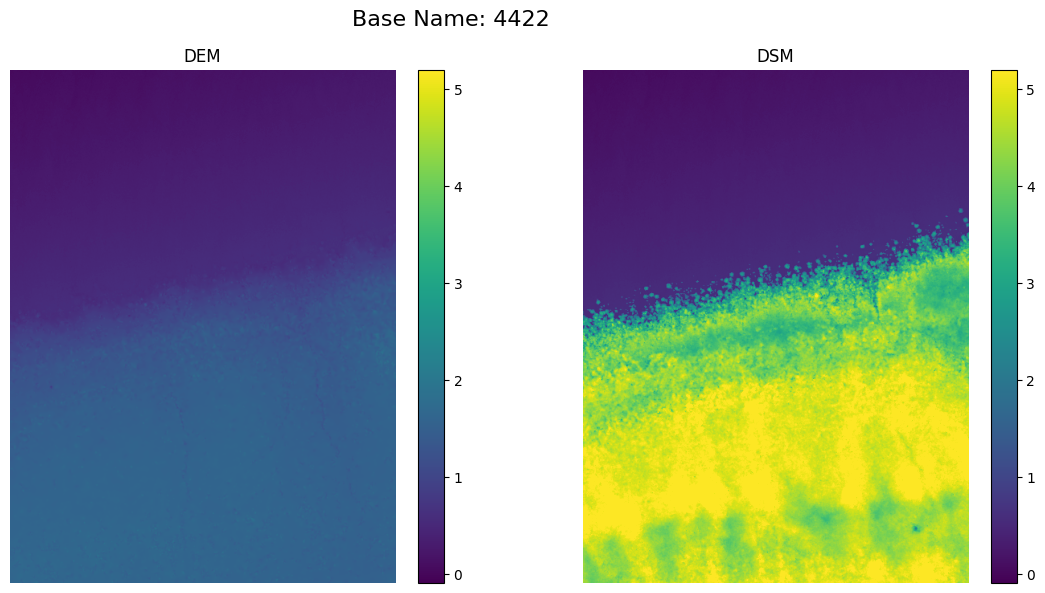

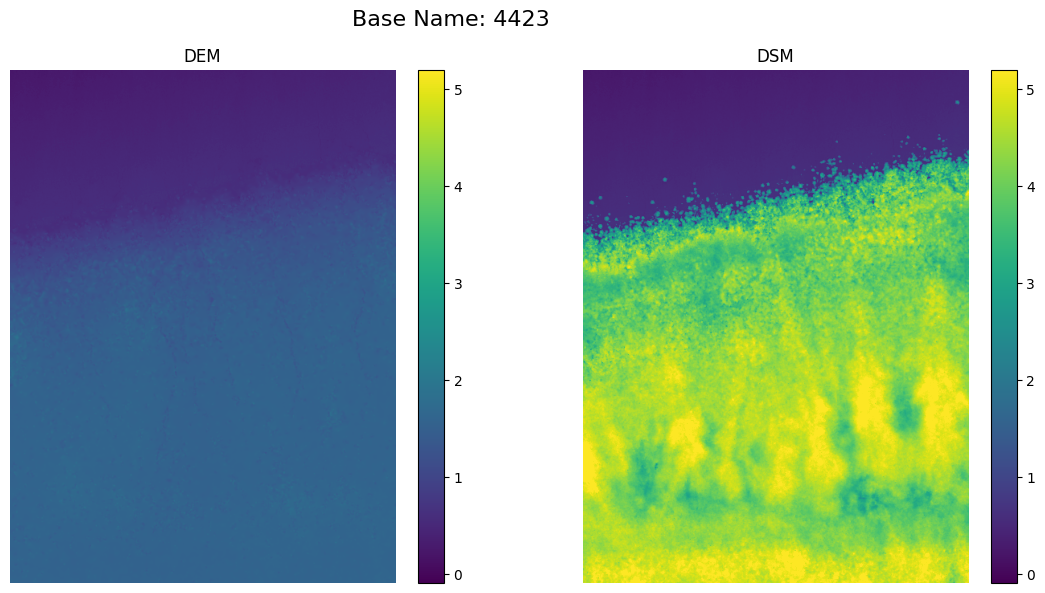

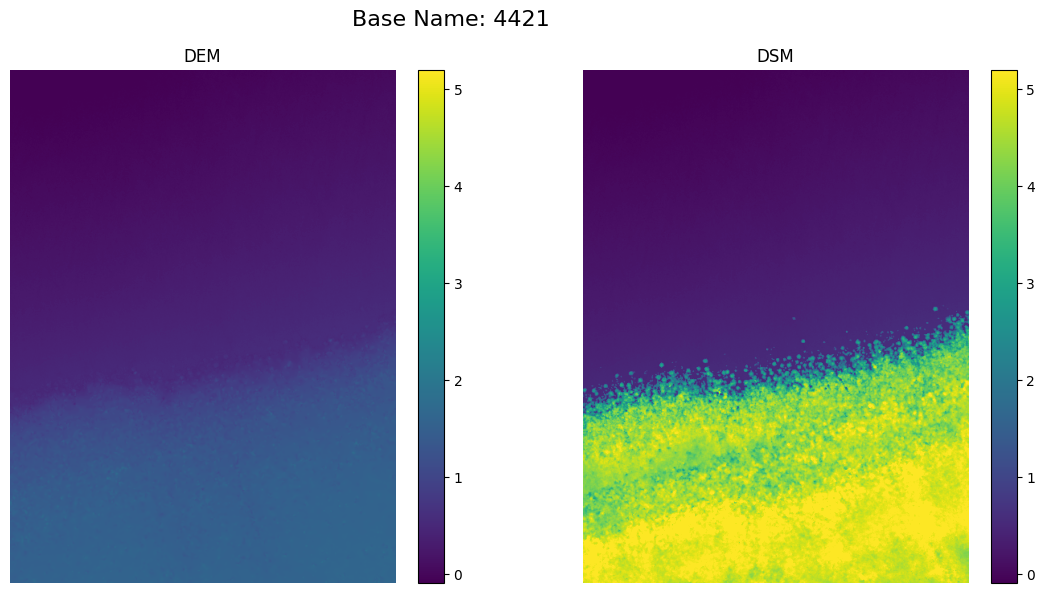

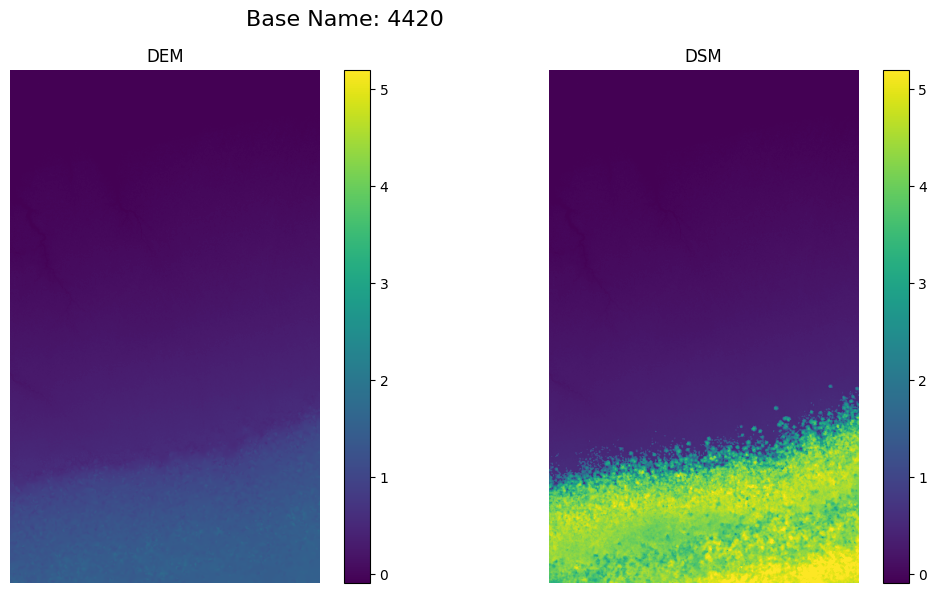

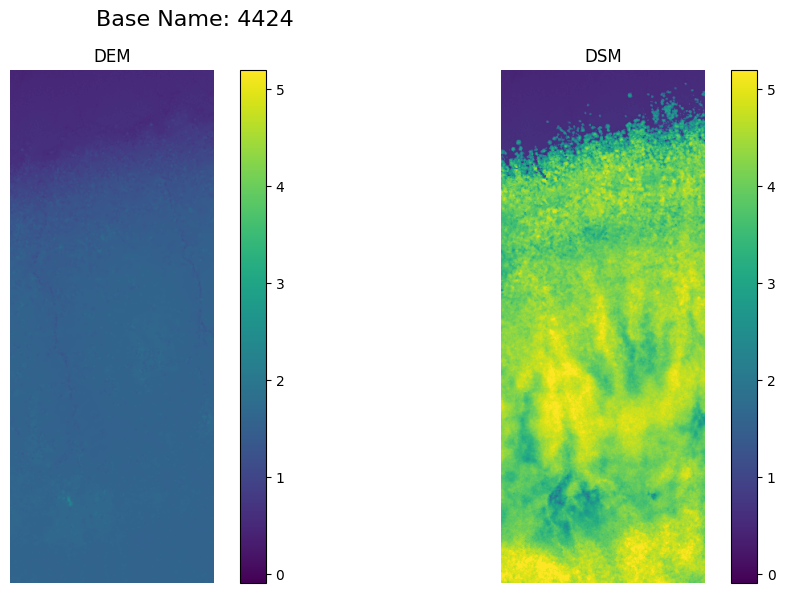

In [7]:
# Plotting DEM and DSM side by side
for base_name, (dem_data, dsm_data) in data.items():
    dem_image, dem_transform = dem_data
    dsm_image, dsm_transform = dsm_data
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Base Name: {base_name}', fontsize=16)

    # DEM image
    ax1 = axes[0]
    im1 = ax1.imshow(dem_image, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('DEM')
    ax1.set_axis_off()
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)  # Add colorbar to the DEM plot

    # DSM image
    ax2 = axes[1]
    im2 = ax2.imshow(dsm_image, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('DSM')
    ax2.set_axis_off()
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)  # Add colorbar to the DSM plot

    plt.tight_layout()
    plt.show()

vmin: sets the minimum data value that corresponds to the lowest value in the colormap. Values below this threshold are mapped to the lowest color in the colormap.

vmax: sets the maximum data value that corresponds to the highest value in the colormap. Values above this threshold are mapped to the highest color in the colormap.

Contrast Enhancement, adjusting vmin and vmax can enhance the visibility of features within a certain range. For example, if most of your data falls within a narrow range, setting vmin and vmax to this range can make subtle variations more apparent.

# Plot three layers

In [8]:
# string base_name from DEM-DSM, top-left point x and y in relative px within DEM-DSM image, side length in m
def overlap(base_name, x, y, side):
    dem_data, dsm_data = data[base_name]
    dem_image, dem_transform = dem_data
    dsm_image, dsm_transform = dsm_data
    aer_image, aer_transform = aer_data
    # window side len in px of dem-dsm image
    # side_px = int(side/dem_transform[0])
    
    # DEM-DSM image width and height
    wd = dem_image.shape[1]
    ht = dem_image.shape[0]
    # window cannot exceed DEM-DSM image boundary
    assert x >= 0
    assert y >= 0
    assert x+side <= wd
    assert y+side <= ht

    # earth real x y coord in m
    x_real = dem_transform.c+x
    y_real = dem_transform.f-y
    # top-left x and y in px of aerial image
    x_aer, y_aer = map(int, ~aer_transform * (x_real, y_real))
    # window side len in px of aerial image
    side_aer_px = int(side/aer_transform[0])
    # window cannot exceed aerial image boundary
    assert x_aer >= 0
    assert y_aer >= 0
    assert x_aer+side_aer_px <= aer_data[0].shape[2]
    assert y_aer+side_aer_px <= aer_data[0].shape[1]
    
    # ((x_start, x_end), (y_start, y_end))
    dem_dsm_window = ((x, x+side), (y, y+side))
    aer_window = ((x_aer, x_aer+side_aer_px), (y_aer, y_aer+side_aer_px))

    # Extract the windows from the images
    dem_crop = dem_image[dem_dsm_window[1][0]:dem_dsm_window[1][1], dem_dsm_window[0][0]:dem_dsm_window[0][1]]
    dsm_crop = dsm_image[dem_dsm_window[1][0]:dem_dsm_window[1][1], dem_dsm_window[0][0]:dem_dsm_window[0][1]]
    aer_crop = aer_data[0][:3, aer_window[1][0]:aer_window[1][1], aer_window[0][0]:aer_window[0][1]]

    return dem_crop, dsm_crop, aer_crop

def plot3(dem_crop, dsm_crop, aer_crop):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot DEM
    axs[0].imshow(dem_crop, cmap='viridis')
    axs[0].set_title(f'DEM - {base_name}')
    axs[0].axis('off')

    # Plot DSM
    axs[1].imshow(dsm_crop, cmap='viridis')
    axs[1].set_title(f'DSM - {base_name}')
    axs[1].axis('off')

    # Plot Aerial Image
    axs[2].imshow(aer_crop.transpose(1, 2, 0))  # Transpose to get (height, width, channels)
    axs[2].set_title(f'Aerial - {base_name}')
    axs[2].axis('off')

    plt.show()

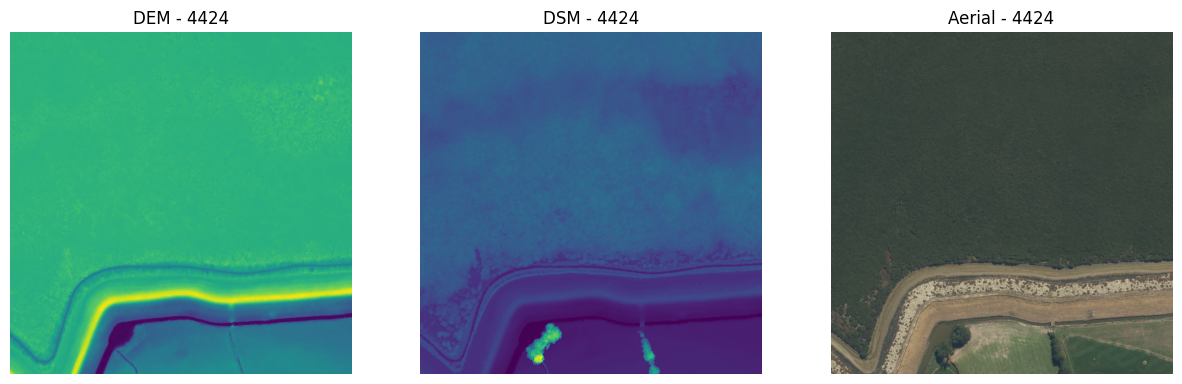

In [9]:
dem_crop, dsm_crop, aer_crop = overlap('4522', 2, 20, 420)
plot3(dem_crop, dsm_crop, aer_crop)